In [1]:
import marimo as mo
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid

# Module 6 - GAN

To approach the problem of image generation in a very generic way we can start with two key components:

- Probability Distribution function $p_{data}(x)$, which assigns to each image the probability of it being a "real image" (alternatively $p_{data}(x | c)$ probability of it being an image representing an object of a certain class).
- A way to sample from that distribution.

The first problem can be addressed using a powerful neural network to model this probability distribution. If $w$ represents the parameters of that distribution, our probability now becomes:

$p_{model}(x | w)$ (or $p_{model}(x | w, c)$ for the conditional case).

However, to define an appropriate loss function we need a way to judge if the generated image is good.

Ideally, we would evaluate the likelyhood function

$-\mathbb{E}_{x \sim p_{data}} (p_{data}(x | w)) \sim -\mathbb{E}_{x \sim p_{data}} (p_{model}(x | w))$,

where $x$ is sampled from the **real** data distribution.

It is usually better to use the logarithm of the likelyhood instead:

$Loss = -\mathbb{E}_{x \sim p_{data}} (\log(p_{data}(x | w))) = -\sum_{i=1}^N \log( p_{data}(x_i | w )$

The problem is that we **do not know** this distribution, so neither evaluating the above loss, nor sampling from this distribution is feasable.

Generative Adversarial Networks (GANs) approach this problem by splitting it into two parts:

- A Generator (G) neural network that learns a mapping from a simple (latent) probability distribution to the data distribution $p_{data}$. It takes a random vector based on a simple probability distribution and generates an image
- A Discriminator (D) neural network (or a critic) that evaluates samples drawn from a training set consisting of images generated by the generator as well as real images.  Hence, the logarithm of the expectation above is approximated with:

$Loss = -\left(\mathbb{E}_{x \sim p_{gen}} (\log(D(x))) + \mathbb{E}_{x \sim p_{real}} \log (1-D(G(x)))\right)$

A trained GAN "synergizes" the two networks so that the generator creates high probability samples.

In [2]:
# Check which GPU is available
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: mps


For this example, we will download the dataset manually instead of using one from the datasets library.

Let's download the dataset.

https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In order to make it available to a PyTorch Dataloader, we need to create a custom dataset class that inherits from the abstract torch.utils.data.Dataset class. At least three methods are required: initializer __init__, __len__ method that returns the total number of examples in the dataset, __getitem__ which returns an example from the dataset based on its index.

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # dummy label (not used in GANs)

In [4]:
BATCH_SIZE = 128

We perform the usual image transformations, but this time we also normalize the image pixels to range from -1 to 1. This is needed if we want to use a tanh activation in the final layer of the generator.

In [5]:
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

custom_dataset = CustomImageDataset(root_dir="../data/img_align_celeba", transform=transform)
dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Note that we could have used datasets.CelebA dataset instead of downloading one manually:
# dataset = datasets.CelebA(root='./data', split='train', download=True, transform=transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

Let's look at the first image in the first batch. We'll need to undo the normalization.

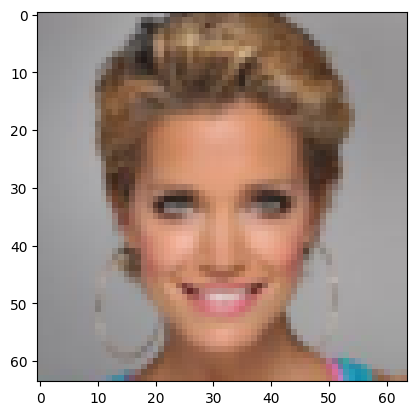

In [6]:
next_batch_images, next_batch_labels = next(iter(dataloader))
_first_img = next_batch_images[0] # retrieve the first image from the batch of 32
_first_img = (_first_img * 0.5) + 0.5
_first_label = next_batch_labels[0] # retrieve the first label from the batch of 32
plt.imshow(_first_img.permute(1, 2, 0), cmap='gray') # imshow requires the image to be in height x width x channels format
plt.show()

We now define the Critic and the Generator neural network architectures.

In [7]:
class Critic(nn.Module):
    def __init__(self):        
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.act1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.act2 = nn.LeakyReLU(0.2, inplace=True)
        #self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.act3 = nn.LeakyReLU(0.2, inplace=True)
        #self.drop3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.act4 = nn.LeakyReLU(0.2, inplace=True)
        #self.drop4 = nn.Dropout(0.3)

        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.act2(x)
        #x = self.drop2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.act3(x)
        #x = self.drop3(x)

        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.act4(x)
        #x = self.drop4(x)

        x = self.conv5(x)
        x = self.flatten(x)

        return x

from torchinfo import summary

_critic = Critic()
print(_critic)
summary(_critic, input_size=(1, 3, 64, 64))

Critic(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 1, ker

Layer (type:depth-idx)                   Output Shape              Param #
Critic                                   [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 32, 32]           3,072
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─LeakyReLU: 1-3                         [1, 64, 32, 32]           --
├─Conv2d: 1-4                            [1, 128, 16, 16]          131,072
├─BatchNorm2d: 1-5                       [1, 128, 16, 16]          256
├─LeakyReLU: 1-6                         [1, 128, 16, 16]          --
├─Conv2d: 1-7                            [1, 256, 8, 8]            524,288
├─BatchNorm2d: 1-8                       [1, 256, 8, 8]            512
├─LeakyReLU: 1-9                         [1, 256, 8, 8]            --
├─Conv2d: 1-10                           [1, 512, 4, 4]            2,097,152
├─BatchNorm2d: 1-11                      [1, 512, 4, 4]            1,024
├─LeakyReLU: 1-12                        [1, 512, 4, 4]    

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.reshape = lambda x: x.view(x.size(0), z_dim, 1, 1)

        self.deconv1 = nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(512, momentum=0.9)
        self.act1 = nn.ReLU(True) # nn.LeakyReLU(0.2, inplace=True)

        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(256, momentum=0.9)
        self.act2 = nn.ReLU(True) # nn.LeakyReLU(0.2, inplace=True)

        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128, momentum=0.9)
        self.act3 = nn.ReLU(True) # nn.LeakyReLU(0.2, inplace=True)

        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64, momentum=0.9)
        self.act4 = nn.ReLU(True) # nn.LeakyReLU(0.2, inplace=True)

        self.deconv5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.reshape(x)

        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.deconv3(x)
        x = self.bn3(x)
        x = self.act3(x)

        x = self.deconv4(x)
        x = self.bn4(x)
        x = self.act4(x)

        x = self.deconv5(x)
        x = self.tanh(x)

        return x

# Example usage
_z_dim = 100
_generator = Generator(_z_dim)

# Print model summary
summary(_generator, input_size=(1, _z_dim), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─ConvTranspose2d: 1-1                   [1, 512, 4, 4]            819,200
├─BatchNorm2d: 1-2                       [1, 512, 4, 4]            1,024
├─ReLU: 1-3                              [1, 512, 4, 4]            --
├─ConvTranspose2d: 1-4                   [1, 256, 8, 8]            2,097,152
├─BatchNorm2d: 1-5                       [1, 256, 8, 8]            512
├─ReLU: 1-6                              [1, 256, 8, 8]            --
├─ConvTranspose2d: 1-7                   [1, 128, 16, 16]          524,288
├─BatchNorm2d: 1-8                       [1, 128, 16, 16]          256
├─ReLU: 1-9                              [1, 128, 16, 16]          --
├─ConvTranspose2d: 1-10                  [1, 64, 32, 32]           131,072
├─BatchNorm2d: 1-11                      [1, 64, 32, 32]           128
├─ReLU: 1-12                             [1, 64, 32, 32] 

Finally we will train a WGAN and after each epoch generate some images from random noise vectors (notice the change in the loss function from the logarithmic loss terms in the regular GAN).

In [9]:
z_dim = 100
lr = 5e-5
n_critic = 5
clip_value = 0.01
epochs = 4

gen = Generator(z_dim).to(device)
critic = Critic().to(device)

opt_gen = optim.RMSprop(gen.parameters(), lr=lr)
opt_critic = optim.RMSprop(critic.parameters(), lr=lr)

fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)

        ## === Train Critic === ##
        for _ in range(n_critic):
            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise).detach()
            critic_real = critic(real).mean()
            critic_fake = critic(fake).mean()
            loss_critic = -(critic_real - critic_fake)

            critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

            # Weight clipping
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        ## === Train Generator === ##
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        loss_gen = -critic(fake).mean()

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {batch_idx}/{len(dataloader)}] "
                  f"[D loss: {loss_critic.item():.4f}] [G loss: {loss_gen.item():.4f}]")

    # Save sample images
    with torch.no_grad():
        fake = gen(fixed_noise).detach().cpu()
    grid = make_grid(fake, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Epoch {epoch}")
    plt.axis("off")
    plt.show()

[Epoch 0/4] [Batch 0/1583] [D loss: -0.0346] [G loss: 0.0142]
[Epoch 0/4] [Batch 100/1583] [D loss: -1.3944] [G loss: 0.6908]
[Epoch 0/4] [Batch 200/1583] [D loss: -1.4569] [G loss: 0.7232]


KeyboardInterrupt: 